In [ ]:
"""
This notebook demonstrates how to construct a Qiskit QuantumCircuit from an
AVQITE file, and use it to compute the expectation values of some observables
using Qiskit StatevectorEstimator.

Packages information:
---------------------
python version = 3.11 (python version >= 3.7 should suffice)
qiskit version = 1.1.1
qiskit[visualization] is required for visualization functionality
"""

In [1]:
import numpy as np
import pickle
from typing import (
    List,
    Optional,
    Tuple,
    Union
)
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import StatevectorEstimator

In [3]:
def add_pauli_rotation_gate(
    qc: "QuantumCircuit",
    pauli_string: str,
    theta: float,
    decompose_rzz: bool = True
):
    """
    Appends a Pauli rotation gate to a QuantumCircuit.
    Convention for Pauli string ordering is opposite to the Qiskit convention.
    For example, in string "XYZ" Pauli "X" acts on the first qubit.

    Parameters
    ----------
    qc : "QuantumCircuit"
        Qiskit "QuantumCircuit" to which the Pauli rotation gate is appended.
    pauli_string : str
        Pauli string defining the rotation.
    theta : float
        Rotation angle.
    decompose_rzz : bool
        If decompose_rzz==True, all rzz gates are decompsed into cx-rz-cx.
        Otherwise, the final circuit contains rzz gates.

    Returns
    -------
    ansatz_adaptvqite : List[str]
        List of Pauli strings entering the ansatz.
    params_adaptvqite : List[float64]
        Parameters (angles) of the ansatz.
    """

    if qc.num_qubits != len(pauli_string):
        raise ValueError("Circuit and Pauli string are of different size")
    if all([pauli=='I' or pauli=='X' or pauli=='Y' or pauli=='Z'
            for pauli in pauli_string])==False:
        raise ValueError("Pauli string does not have a correct format")

    nontriv_pauli_list = [(i,pauli)
                        for i,pauli in enumerate(pauli_string) if pauli!='I']
    for (i,pauli) in nontriv_pauli_list:
        if pauli=='X':
            qc.h(i)
        if pauli=='Y':
            qc.sdg(i)
            qc.h(i)
    for list_ind in range(len(nontriv_pauli_list)-2):
        qc.cx(nontriv_pauli_list[list_ind][0],nontriv_pauli_list[list_ind+1][0])
    if decompose_rzz==True:
        qc.cx(
            nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
            nontriv_pauli_list[len(nontriv_pauli_list)-1][0]
            )
        qc.rz(theta,nontriv_pauli_list[len(nontriv_pauli_list)-1][0])
        qc.cx(
            nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
            nontriv_pauli_list[len(nontriv_pauli_list)-1][0]
            )
    if decompose_rzz==False:
        qc.rzz(
            theta,
            nontriv_pauli_list[len(nontriv_pauli_list)-2][0],
            nontriv_pauli_list[len(nontriv_pauli_list)-1][0]
            )
    for list_ind in reversed(range(len(nontriv_pauli_list)-2)):
        qc.cx(nontriv_pauli_list[list_ind][0],nontriv_pauli_list[list_ind+1][0])
    for (i,pauli) in nontriv_pauli_list:
        if pauli=='X':
            qc.h(i)
        if pauli=='Y':
            qc.h(i)
            qc.s(i)
    return qc


class QiskitCircuitGeneratorAVQITE:
    """
    Class for reading out the AVQITE ansatz and incar files, and constructing
    a Qiskit QuantumCircuit object representing the ansatz.

    Attributes
    ----------
    ansatz_filename : str
        File name of the ansatz file, including the path.
        For this implementation, "ansatz_inp.pkle" type of ansatz files is used.
    incar_filename : str
        File name of the incar file, including the path.
        Incar file is used to read out the reference state.
    """
    def __init__(
        self,
        ansatz_filename: str,
        incar_filename: str
    ):
        self._ansatz_filename = ansatz_filename
        self._incar_filename = incar_filename

        #Reads out the operator list and the parameter list of the ansatz.
        (self._ansatz_adaptvqite,
         self._params_ansatz) = self.read_adaptvqite_ansatz(ansatz_filename)

        #Reads out the number of qubits.
        self._num_qubits = len(self._ansatz_adaptvqite[0])

        #Reads out the incar file.
        with open(incar_filename) as fp:
            incar_content = fp.read()
        ref_st_r_pos = incar_content.find("ref_state")
        #Reads out the reference state from the incar file.
        self._ref_state = incar_content[
                            ref_st_r_pos+13:ref_st_r_pos+13+self._num_qubits
                            ]

        #Initializes a QuantumCircuit object.
        self._init_qc = QuantumCircuit(self._num_qubits)

        #If the reference state contains "1"s, adds corresponding bit-flips.
        if all([(el=='0') or (el=='1') for el in self._ref_state]):
            self._init_qc.x(
                [i for i,el in enumerate(self._ref_state) if el=='1']
            )
        else:
            raise ValueError(
                "Reference state is supposed to be a string of 0s and 1s"
            )
            
            
    def read_adaptvqite_ansatz(
        self,
        filename: str
    ):
        """
        Reads the ansatz from a file resulting from adaptvqite calculation.

        Parameters
        ----------
        filename : str
            Name of a file containing the results of adaptvqite calculation.
            Has to be given in .pkle format.

        Returns
        -------
        ansatz_adaptvqite : List[str]
            List of Pauli strings entering the ansatz.
        params_adaptvqite : List[float64]
            Parameters (angles) of the ansatz.
        """
        if filename[-5:] != '.pkle':
            raise ImportError("Ansatz file should be given in .pkle format")
        with open(filename, 'rb') as inp:
            data_inp = pickle.load(inp)
            ansatz_adaptvqite = data_inp[0]
            params_adaptvqite = data_inp[1]
        return ansatz_adaptvqite, params_adaptvqite
    
    
    def construct_ansatz_qc(
        self,
        decompose_rzz: bool
    ):
        """
        Constructs a "QuantumCircuit" representing the AVQITE ansatz.

        Parameters
        ----------
        decompose_rzz : bool
            If decompose_rzz==True, all rzz gates are decompsed into cx-rz-cx.
            Otherwise, the final circuit contains rzz gates.

        Returns
        -------
        qc : "QuantumCircuit"
            "QuantumCircuit" representing the AVQITE ansatz.
        """
        qc = self._init_qc.copy()
    
        #Adds (potentially multi-qubit) Pauli rotation gates to the circuit
        #from the ansatz using "add_pauli_rotation_gate" function.
        #Option "decompose_rzz=False" can be used to not decompose rzz gates
        #into cx-rz-cx
        for i, pauli_string in enumerate(self._ansatz_adaptvqite):
            theta = self._params_ansatz[i]
            qc = add_pauli_rotation_gate(
                qc,
                pauli_string,
                theta,
                decompose_rzz
            )
        return qc

## Constructing the circuit from the ansatz

In [4]:
%%time

#qc is the circuit in the final from that we need

model = QiskitCircuitGeneratorAVQITE(ansatz_filename='ansatz_inp.pkle', incar_filename='incar')
qc = model.construct_ansatz_qc(decompose_rzz=False)

CPU times: user 5.55 ms, sys: 0 ns, total: 5.55 ms
Wall time: 6.73 ms


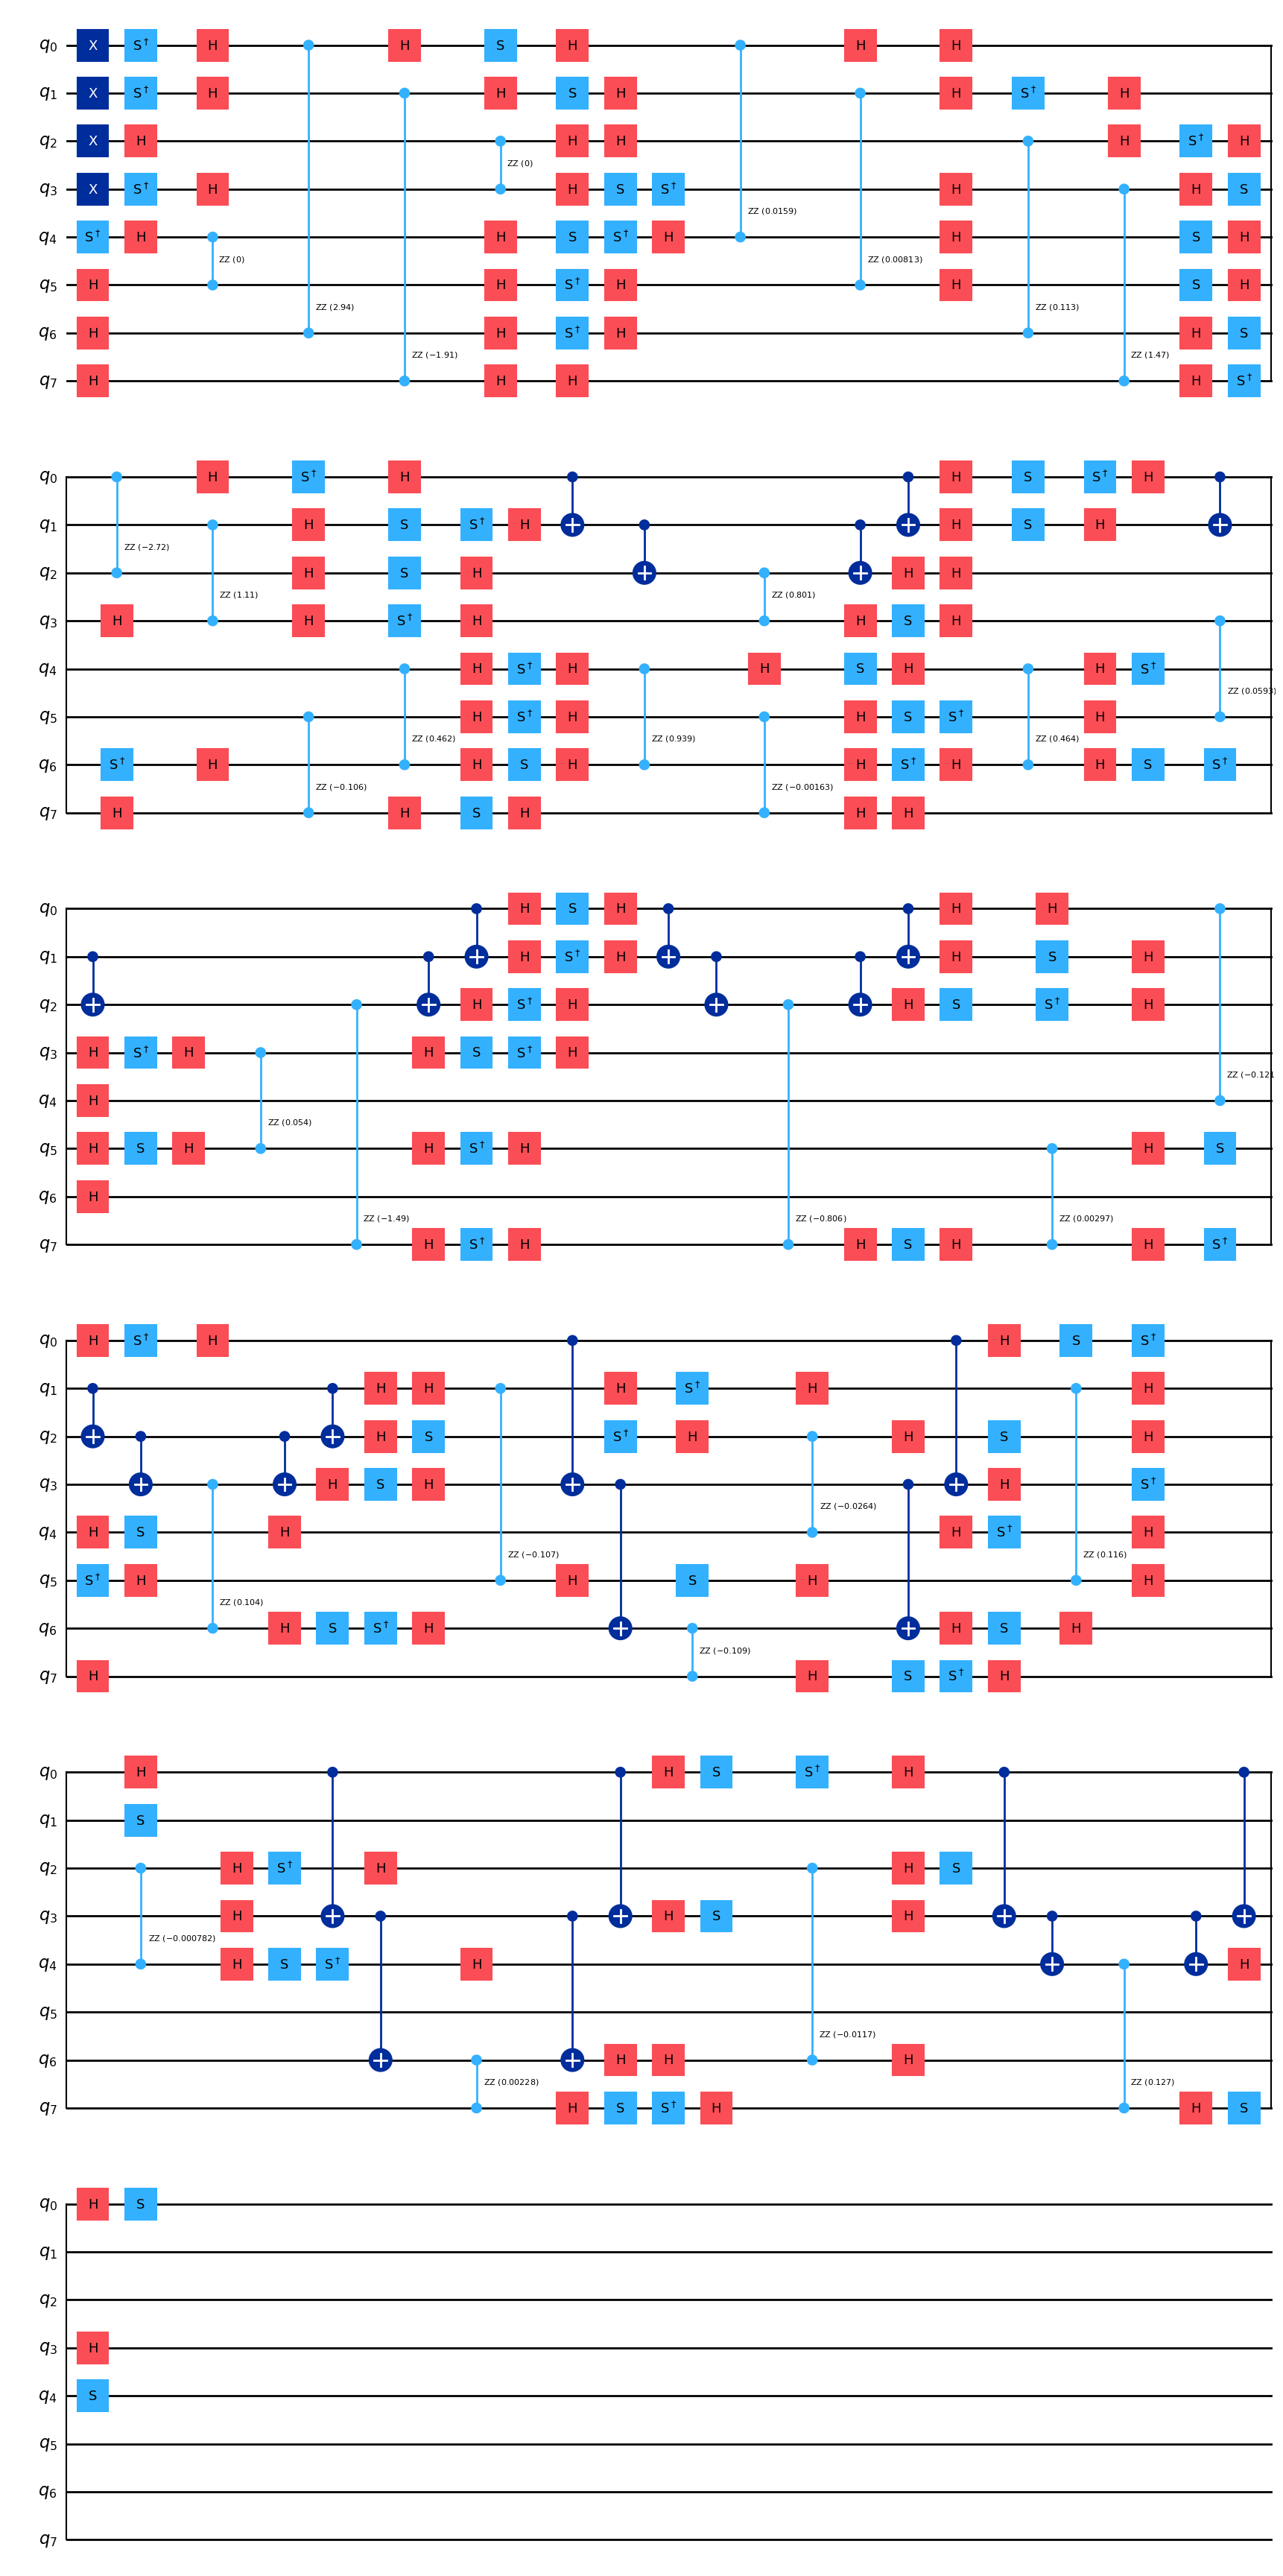

In [5]:
#draws the obtained circuit

qc.draw('mpl')

In [18]:
#Saves qc as an object via pickle

with open("qc_custom_pauli_rot.pkle", "wb") as f:
    pickle.dump(qc, f)

## Computing expectation values of observables

In [7]:
obs_list_2D = [
        [
            "0.5*IIIIIIII",
            "-0.5*ZIIIIIII"
        ],
        [
            "0.25*YZYIIIII",
            "0.25*XZXIIIII"
        ],
        [
            "0.25*YZZZYIII",
            "0.25*XZZZXIII"
        ],
        [
            "0.25*YZZZZZYI",
            "0.25*XZZZZZXI"
        ],
        [
            "0.5*IIIIIIII",
            "-0.5*IIZIIIII"
        ],
        [
            "0.25*IIYZYIII",
            "0.25*IIXZXIII"
        ],
        [
            "0.25*IIYZZZYI",
            "0.25*IIXZZZXI"
        ],
        [
            "0.5*IIIIIIII",
            "-0.5*IIIIZIII"
        ],
        [
            "0.25*IIIIYZYI",
            "0.25*IIIIXZXI"
        ],
        [
            "0.5*IIIIIIII",
            "-0.5*IIIIIIZI"
        ],
        [
            "0.25*IIIIIIII",
            "-0.25*IZIIIIII",
            "-0.25*ZIIIIIII",
            "0.25*ZZIIIIII"
        ]
    ]

In [8]:
# Converts the list of observables into the Qiskit format

obs_list_qiskit=[]

for obs_row in obs_list_2D:
    pauli_strings_list = []
    params_list = []
    for obs in obs_row:
        pauli = "".join([i for i in obs if (i=="I" or i=="X" or i=="Y" or i=="Z")])
        coeff = float("".join([i for i in obs if (i=="-" or i=="." or i.isdigit())]))
        pauli_strings_list.append(pauli[::-1])
        params_list.append(coeff)
    
    obs_list_qiskit.append([SparsePauliOp(pauli_strings_list, params_list)])

In [9]:
obs_list_qiskit

[[SparsePauliOp(['IIIIIIII', 'IIIIIIIZ'],
                coeffs=[ 0.5+0.j, -0.5+0.j])],
 [SparsePauliOp(['IIIIIYZY', 'IIIIIXZX'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IIIYZZZY', 'IIIXZZZX'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IYZZZZZY', 'IXZZZZZX'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IIIIIIII', 'IIIIIZII'],
                coeffs=[ 0.5+0.j, -0.5+0.j])],
 [SparsePauliOp(['IIIYZYII', 'IIIXZXII'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IYZZZYII', 'IXZZZXII'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IIIIIIII', 'IIIZIIII'],
                coeffs=[ 0.5+0.j, -0.5+0.j])],
 [SparsePauliOp(['IYZYIIII', 'IXZXIIII'],
                coeffs=[0.25+0.j, 0.25+0.j])],
 [SparsePauliOp(['IIIIIIII', 'IZIIIIII'],
                coeffs=[ 0.5+0.j, -0.5+0.j])],
 [SparsePauliOp(['IIIIIIII', 'IIIIIIZI', 'IIIIIIIZ', 'IIIIIIZZ'],
                coeffs=[ 0.25+0.j, -0.25+0.j

In [10]:
# Computes expectation values using Qiskit StatevectorEstimator

estimator = StatevectorEstimator()
pub = (qc, obs_list_qiskit)
job = estimator.run([pub],precision=1e-10)
result = job.result()[0]

In [11]:
result.data.evs

array([[ 0.48911703],
       [ 0.20681802],
       [ 0.05769926],
       [ 0.05068355],
       [ 0.50892231],
       [ 0.03037431],
       [-0.01917516],
       [ 0.00724491],
       [-0.00123756],
       [ 0.99470818],
       [ 0.02384612]])

In [12]:
#Creates a dictionary of the expectation values and prints them out

expec_val_data = dict()
for i in range(len(obs_list_2D)):
    expec_val_data[str(obs_list_2D[i])] = result.data.evs[i]
expec_val_data

{"['0.5*IIIIIIII', '-0.5*ZIIIIIII']": array([0.48911703]),
 "['0.25*YZYIIIII', '0.25*XZXIIIII']": array([0.20681802]),
 "['0.25*YZZZYIII', '0.25*XZZZXIII']": array([0.05769926]),
 "['0.25*YZZZZZYI', '0.25*XZZZZZXI']": array([0.05068355]),
 "['0.5*IIIIIIII', '-0.5*IIZIIIII']": array([0.50892231]),
 "['0.25*IIYZYIII', '0.25*IIXZXIII']": array([0.03037431]),
 "['0.25*IIYZZZYI', '0.25*IIXZZZXI']": array([-0.01917516]),
 "['0.5*IIIIIIII', '-0.5*IIIIZIII']": array([0.00724491]),
 "['0.25*IIIIYZYI', '0.25*IIIIXZXI']": array([-0.00123756]),
 "['0.5*IIIIIIII', '-0.5*IIIIIIZI']": array([0.99470818]),
 "['0.25*IIIIIIII', '-0.25*IZIIIIII', '-0.25*ZIIIIIII', '0.25*ZZIIIIII']": array([0.02384612])}

## Check using SciPy

In [13]:
import scipy

In [14]:
state = np.zeros(2**8)
state[0] = 1.0

state = SparsePauliOp(['IIIIIIIX'], [1.0]).to_matrix() @ state
state = SparsePauliOp(['IIIIIIXI'], [1.0]).to_matrix() @ state
state = SparsePauliOp(['IIIIIXII'], [1.0]).to_matrix() @ state
state = SparsePauliOp(['IIIIXIII'], [1.0]).to_matrix() @ state

In [15]:
for i,pauli_string in enumerate(model._ansatz_adaptvqite):
    state = scipy.linalg.expm(-1j/2*SparsePauliOp([pauli_string[::-1]],[model._params_ansatz[i]]).to_matrix()) @ state

In [16]:
state.conjugate().transpose() @ SparsePauliOp(['IIIIIIII','IIIIIIIZ'], [0.5,-0.5]).to_matrix() @ state

(0.48911702639103727+0j)

In [17]:
state.conjugate().transpose() @ SparsePauliOp(['IIIIIYZY','IIIIIXZX'], [0.25,0.25]).to_matrix() @ state

(0.20681802315313205+0j)